![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
# Librerías
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

def mse_reduction(X_col, y, split):

    filter_l = X_col < split
    y_l = y[filter_l]
    y_r = y[~filter_l]

    mse_total = mse(y)

    mse_l = mse(y_l)
    mse_r = mse(y_r)

    n_l, n_r = len(y_l), len(y_r)
    mse_reduction_ = mse_total - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_reduction_

def best_split(X, y, num_pct=10):
    best = [None, None, -np.inf]

    for j in range(X.shape[1]):
        col = X.iloc[:, j]

        if col.dtype == bool or set(col.unique()) <= {0, 1}:
            splits = [0.5]
        else:
            splits = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2))[1:-1]
            splits = np.unique(splits)

        for split in splits:
            gain = mse_reduction(X.iloc[:, j], y, split)
            if gain > best[2]:
                best = [j, split, gain]

    return best

def tree_grow(X,y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    if len(y) <= 1 or (max_depth is not None and level >= max_depth):
        return {'pred': np.mean(y), 'split': -1}

    j, split, gain = best_split(X, y, num_pct)
    if gain < min_gain:
        return {'pred': np.mean(y), 'split': -1}

    mask = X.iloc[:, j] < split
    left = tree_grow(X[mask], y[mask], level + 1, min_gain, max_depth, num_pct)
    right = tree_grow(X[~mask], y[~mask], level + 1, min_gain, max_depth, num_pct)

    return {
        'split': (j,split),
        'left': left,
        'right': right,
        'pred': np.mean(y)
    }

def tree_predict(x, tree):
    if tree['split'] == -1:
        return tree['pred']
    j, split = tree['split']
    if x[j] < split:
        return tree_predict(x, tree['left'])
    else:
        return tree_predict(x, tree['right'])

def predict_tree(X, tree):
    return X.apply(lambda row: tree_predict(row,tree), axis=1)

def cross_val_metrics(X, y, k=5, **tree_params):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    rmse_list = []
    mae_list = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        tree = tree_grow(X_train, y_train, **tree_params)
        y_pred = predict_tree(X_val, tree)

        rmse_list.append(root_mean_squared_error(y_val, y_pred))
        mae_list.append(mean_absolute_error(y_val, y_pred))

    return np.mean(rmse_list), np.mean(mae_list)

rmse_cv, mae_cv = cross_val_metrics(X_train, y_train, k=5, max_depth=None, num_pct=10, min_gain=0.001)
print("CV RMSE :", rmse_cv)
print("CV MAE:", mae_cv)  

tree = tree_grow(X_train, y_train, max_depth=None, num_pct=10, min_gain=0.001)

y_pred_test = predict_tree(X_test, tree)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)    

CV RMSE : 2117.7601131314086
CV MAE: 1583.7609810124345
Test RMSE: 2145.236393110967
Test MAE: 1597.4042051578137


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2
# Validación cruzada manual 5-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ñistas para almacenar datos
rmse_folds = []
mse_folds = []
mae_folds = []
errores_por_arbol = []

# condicion de validación cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Cantidad de arboles 10 y union de entrenamiento para el bootstrap
    train_fold = pd.concat([y_tr, X_tr], axis=1)
    n_samples = train_fold.shape[0]
    n_B = 10
    np.random.seed(0)
    samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]

    # Crear modelo y predicciones
    treereg = DecisionTreeRegressor(max_depth=None, random_state=0)
    y_pred_arboles = pd.DataFrame(index=X_val.index, columns=[f'Árbol {i+1}' for i in range(n_B)])
    errores_arbol = []

    # Generar modelo y almacenar resultados
    for i, sample in enumerate(samples):
        X_boot = train_fold.iloc[sample, 1:]
        y_boot = train_fold.iloc[sample, 0]
        treereg.fit(X_boot, y_boot)
        pred = treereg.predict(X_val)
        y_pred_arboles.iloc[:, i] = pred

        rmse_i = np.sqrt(mean_squared_error(y_val, pred))
        errores_arbol.append(rmse_i)

    errores_por_arbol.append(errores_arbol)

    # Promediar predicciones Bagging
    y_pred_prom = y_pred_arboles.mean(axis=1)

    # Calcular métricas del modelo
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_prom))
    mse = mean_squared_error(y_val, y_pred_prom)
    mae = mean_absolute_error(y_val, y_pred_prom)

    rmse_folds.append(rmse)
    mse_folds.append(mse)
    mae_folds.append(mae)

# Crear tabla de errores del modelo Bagging
cv_manual_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'RMSE Bagging': rmse_folds,
    'MSE Bagging': mse_folds,
    'MAE Bagging': mae_folds
})
cv_manual_results.loc[len(cv_manual_results.index)] = [
    'Promedio',
    np.mean(rmse_folds),
    np.mean(mse_folds),
    np.mean(mae_folds)
]

# Crear tabla de errores individuales de los árboles
df_errores_arboles = pd.DataFrame(errores_por_arbol,
                                  columns=[f'Árbol {i+1}' for i in range(n_B)],
                                  index=[f'Fold {i+1}' for i in range(5)])

# Generar resultados
print("Errores individuales de los 10 árboles por fold (RMSE)")
display(df_errores_arboles)

print(" Resultados del modelo Bagging Manual (con promedio de predicciones)")
display(cv_manual_results)

Errores individuales de los 10 árboles por fold (RMSE)


,Árbol 1,Árbol 2,Árbol 3,Árbol 4,Árbol 5,Árbol 6,Árbol 7,Árbol 8,Árbol 9,Árbol 10
Fold 1,2098.093235,2169.736687,2184.325243,2149.289577,2055.240184,2136.004816,2148.974875,2106.506652,2084.270393,2093.950091
Fold 2,2117.819638,2060.965928,2087.919507,2134.789508,2165.186737,2133.675918,2124.178383,2157.784681,2235.866811,2156.037095
Fold 3,2193.895488,2162.279841,2128.505920,2051.644383,2147.385899,2117.186019,2040.636353,2171.851754,2105.432417,2201.459381
Fold 4,2177.574422,2110.902385,2073.852274,2133.160595,2152.306169,2176.528696,2248.847727,2132.660164,2130.130672,2078.786383
Fold 5,2011.581932,2146.489143,2021.513671,2070.595118,2063.014469,2088.398531,2204.148698,2045.934532,2086.830968,2041.894361


 Resultados del modelo Bagging Manual (con promedio de predicciones)


,Fold,RMSE Bagging,MSE Bagging,MAE Bagging
0,Fold 1,1789.296420,3.201582e+06,1343.559611
1,Fold 2,1791.452355,3.209302e+06,1350.677866
2,Fold 3,1797.044455,3.229369e+06,1327.796826
3,Fold 4,1774.168898,3.147675e+06,1328.671100
4,Fold 5,1728.825263,2.988837e+06,1290.166204
5,Promedio,1776.157478,3.155353e+06,1328.174321


Cada arbol de manera individual tienen un RMSE superior a 2000, sin embargo al promediar las predicciones de los 10 arboles el error disminuye significarivamente en los folds, viendo que el promerdio del RMSE del modelo bagging fue de 1776, mucho menor que los errores que se generan de manera individual con los arboles. esto ya que cada arbol por separado puede cometer diferentes errores y la combinacion de estos suaviza el error, mostrando que el modelo final sea más preciso y estable.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [7]:
# Celda 3
# modelo Bagging con condiciones del max_features
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=int(np.log(X_train.shape[1])),
    bootstrap=True,
    oob_score=True,
    random_state=0
)

# Validacion cruzada sobre train
rmse_scores = cross_val_score(bagging_model, X_train, y_train, cv=5,
                              scoring='neg_root_mean_squared_error')
mse_scores = cross_val_score(bagging_model, X_train, y_train, cv=5,
                             scoring='neg_mean_squared_error')
mae_scores = cross_val_score(bagging_model, X_train, y_train, cv=5,
                             scoring='neg_mean_absolute_error')

# Convertir errorres a valores positivos y generar tabla con cada uno de los resultados
rmse_scores = -rmse_scores
mse_scores = -mse_scores
mae_scores = -mae_scores

cv_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'RMSE': rmse_scores,
    'MSE': mse_scores,
    'MAE': mae_scores
})

# calculo de los promedios y resultados
cv_results.loc[len(cv_results.index)] = [
    'Promedio',
    rmse_scores.mean(),
    mse_scores.mean(),
    mae_scores.mean()
]

display(cv_results)

,Fold,RMSE,MSE,MAE
0,Fold 1,2411.972690,5.817612e+06,1843.816271
1,Fold 2,2354.223869,5.542370e+06,1793.655693
2,Fold 3,2375.286064,5.641984e+06,1844.521604
3,Fold 4,2352.082145,5.532290e+06,1856.614848
4,Fold 5,2334.258113,5.448761e+06,1793.737522
5,Promedio,2365.564576,5.596604e+06,1826.469188


El modelo de bagging de libreria en su implementación mostro un desempeño inferior(2365) al modelo de bagging manual(1776), lo que nos da a concluir que las deciciones que se tomen al momento de ajustar parametros tienen un impacto importante en este caso el max_features, donde al ajustar estos valores de manera adecuada pueden mejorar el desempeño.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [8]:
# Generamos el modelo Random Forest para regresión sin calibrar
reg = RandomForestRegressor(random_state=0)
reg = RandomForestRegressor()
reg

RandomForestRegressor()

In [9]:
# Semilla para todos los cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Realizamos análisis estadístico del modelo sin parametrizar sobre el conjunto de train
# Lo multiplicamos por -1 para que el análisis salga en positivo
pd.Series(-cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')).describe()

count       5.000000
mean     1739.993905
std        35.994023
min      1683.271748
25%      1734.333324
50%      1740.576373
75%      1767.513406
max      1774.274675
dtype: float64

In [11]:
# Entrenamos el modelo de árbol de decisión sin parametrizar
reg.fit(X_train, y_train)

RandomForestRegressor()

In [12]:
# Realizamos las predicciones del modelo
y_pred = reg.predict(X_test)

### Validación

In [13]:
# Realizamos pruebas de validación con MSE, RMSE y MAE
mse_sin_calibrar = mean_squared_error(y_test, y_pred)
rmse_sin_calibrar = root_mean_squared_error(y_test, y_pred)
mae_sin_calibrar = mean_absolute_error(y_test, y_pred)

print(f"MSE en entrenamiento: {mse_sin_calibrar:.2f}")
print(f"RMSE en entrenamiento: {rmse_sin_calibrar:.2f}")
print(f"MAE en entrenamiento:  {mae_sin_calibrar:.2f}")

MSE en entrenamiento: 3107789.08
RMSE en entrenamiento: 1762.89
MAE en entrenamiento:  1310.41


### Con validación cruzada

In [14]:
# Validación cruzada con MSE
mse_cv = -cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("Resumen MSE de validación cruzada en modelo sin calibrar:")
print(pd.Series(mse_cv).describe())

Resumen MSE de validación cruzada en modelo sin calibrar:
count    5.000000e+00
mean     3.020061e+06
std      1.081546e+05
min      2.859006e+06
25%      2.989085e+06
50%      3.013268e+06
75%      3.113188e+06
max      3.125761e+06
dtype: float64


In [15]:
# Validación cruzada con RMSE
rmse_cv = -cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print("Resumen RMSE de validación cruzada en modelo sin calibrar:")
pd.Series(rmse_cv).describe()

Resumen RMSE de validación cruzada en modelo sin calibrar:


count       5.000000
mean     1738.530081
std        34.154250
min      1686.146592
25%      1732.876930
50%      1735.311439
75%      1767.816278
max      1770.499164
dtype: float64

In [16]:
# MAE
mae_cv = -cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print("Resumen MAE de validación cruzada en modelo sin calibrar:")
pd.Series(mae_cv).describe()

Resumen MAE de validación cruzada en modelo sin calibrar:


count       5.000000
mean     1300.231858
std        22.877773
min      1260.805165
25%      1302.991156
50%      1306.774588
75%      1311.114651
max      1319.473731
dtype: float64

### Análisis
El realizar el entrenamiento del modelo, sin hacer uso de parametrización, este va a ejecutar los parámetros por default, en este caso, se podría esperar que el modelo pueda estar sobreajustado antes de realizar la validación cruzada. Al comparar las métricas de control luego de realizar la validación cruzada, se encuentra que los resultados con 5 folds, son un poco interiores a la evaluación original. En tanto, es posible concluir que el modelo no está sobreajustado.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### Calibración de n_estimators

In [17]:
# Definimos rango y saltos para encontrar un número óptimo de estimadores
estimator_range = range(10, 310, 10)
mse_scores = []

# Se mantiene los 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=0)
    mse = -cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

for n, score in zip(estimator_range, mse_scores):
    print(f"n_estimators = {n}: MSE promedio = {score:.2f}")

min_mse_1 = min(mse_scores)
optimal_n_estimators = estimator_range[mse_scores.index(min_mse_1)]

print(f"\nEl menor MSE es {min_mse_1:.2f}, obtenido con n_estimators = {optimal_n_estimators}")

n_estimators = 10: MSE promedio = 3118230.84
n_estimators = 20: MSE promedio = 3066926.69
n_estimators = 30: MSE promedio = 3044593.65
n_estimators = 40: MSE promedio = 3033870.07
n_estimators = 50: MSE promedio = 3032125.26
n_estimators = 60: MSE promedio = 3031085.78
n_estimators = 70: MSE promedio = 3029331.92
n_estimators = 80: MSE promedio = 3033477.13
n_estimators = 90: MSE promedio = 3031439.83
n_estimators = 100: MSE promedio = 3031475.89
n_estimators = 110: MSE promedio = 3027984.74
n_estimators = 120: MSE promedio = 3028026.42
n_estimators = 130: MSE promedio = 3030311.76
n_estimators = 140: MSE promedio = 3029939.94
n_estimators = 150: MSE promedio = 3028457.14
n_estimators = 160: MSE promedio = 3026690.53
n_estimators = 170: MSE promedio = 3027478.82
n_estimators = 180: MSE promedio = 3026166.55
n_estimators = 190: MSE promedio = 3025537.25
n_estimators = 200: MSE promedio = 3023547.10
n_estimators = 210: MSE promedio = 3023193.31
n_estimators = 220: MSE promedio = 3023175.

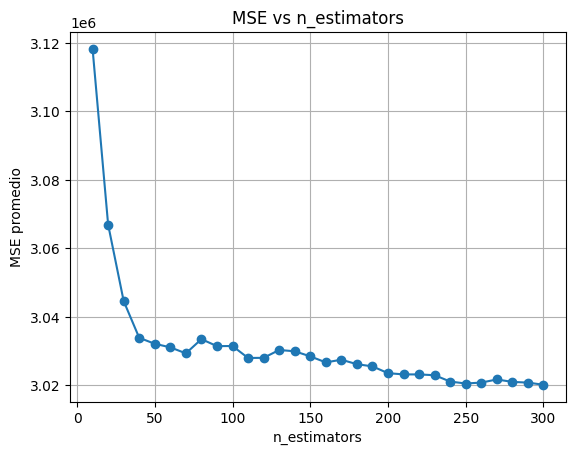

In [18]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores, marker='o')
plt.title("MSE vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("MSE promedio")
plt.grid(True)
plt.show()

#### Valor óptimo de n_estimators: 300

### Calibración de max_features

In [19]:
features_options = ['sqrt', 'log2', None]
mse_scores = []

for feat in features_options:
    reg = RandomForestRegressor(n_estimators=300, max_features=feat, random_state=0)
    mse = -cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

for f, score in zip(features_options, mse_scores):
    print(f"max_features = {f}: MSE promedio = {score:.2f}")

min_mse_2 = min(mse_scores)
optimal_max_features = features_options[mse_scores.index(min_mse_2)]

print(f"\nEl menor MSE es {min_mse_2:.2f}, obtenido con max_features = {optimal_max_features}")

max_features = sqrt: MSE promedio = 3091670.09
max_features = log2: MSE promedio = 3091670.09
max_features = None: MSE promedio = 3020158.77

El menor MSE es 3020158.77, obtenido con max_features = None


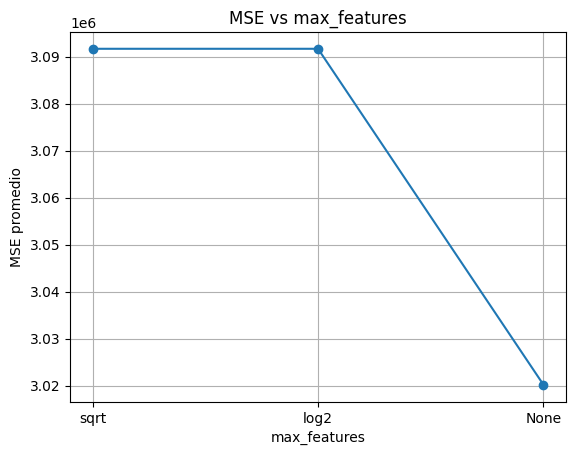

In [20]:
plt.plot([str(f) for f in features_options], mse_scores, marker='o')
plt.title("MSE vs max_features")
plt.xlabel("max_features")
plt.ylabel("MSE promedio")
plt.grid(True)
plt.show()

#### Valor óptimo de max_features: None

### Calibracióm max_depth

In [21]:
depth_range = list(range(2, 21))
mse_scores = []

# Validación cruzada para cada valor de max_depth
for depth in depth_range:
    reg = RandomForestRegressor(n_estimators=300, max_features= None, max_depth=depth, random_state=0)
    mse = -cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

# Mostrar resultados
for d, score in zip(depth_range, mse_scores):
    print(f"max_depth = {d}: MSE promedio = {score:.2f}")

min_mse_3 = min(mse_scores)
optimal_max_depth = depth_range[mse_scores.index(min_mse_3)]

print(f"\nEl menor MSE es {min_mse_3:.2f}, obtenido con max_depth = {optimal_max_depth}")

max_depth = 2: MSE promedio = 3978101.40
max_depth = 3: MSE promedio = 3230524.28
max_depth = 4: MSE promedio = 2811756.00
max_depth = 5: MSE promedio = 2556179.76
max_depth = 6: MSE promedio = 2408606.85
max_depth = 7: MSE promedio = 2342490.42
max_depth = 8: MSE promedio = 2335899.98
max_depth = 9: MSE promedio = 2363458.39
max_depth = 10: MSE promedio = 2415771.64
max_depth = 11: MSE promedio = 2481067.74
max_depth = 12: MSE promedio = 2552590.42
max_depth = 13: MSE promedio = 2624974.76
max_depth = 14: MSE promedio = 2695649.44
max_depth = 15: MSE promedio = 2759274.11
max_depth = 16: MSE promedio = 2811812.48
max_depth = 17: MSE promedio = 2858176.62
max_depth = 18: MSE promedio = 2892376.46
max_depth = 19: MSE promedio = 2920951.32
max_depth = 20: MSE promedio = 2942045.03

El menor MSE es 2335899.98, obtenido con max_depth = 8


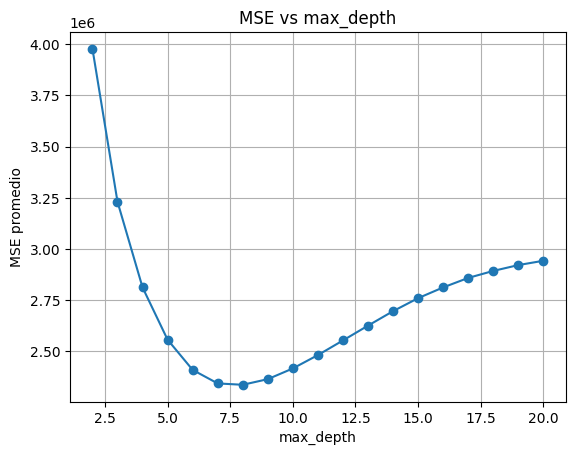

In [22]:
plt.plot(depth_range, mse_scores, marker='o')
plt.title("MSE vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("MSE promedio")
plt.grid(True)
plt.show()

#### Valor óptimo de max_depth: 8

### Modelo calibrado de forma manual

In [23]:
red_ajustado = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    max_features= None,
    random_state=0
)
red_ajustado.fit(X_train, y_train)
predicciones = red_ajustado.predict(X_test)

In [24]:
mse_manual = mean_squared_error(y_test, predicciones)
rmse_manual = np.sqrt(mse_manual)
mae_manual = mean_absolute_error(y_test, predicciones)
print(f"MSE del modelo final ajustado: {mse_manual:.2f}")
print(f"RMSE del modelo final ajustado: {rmse_manual:.2f}")
print(f"MAE del modelo final ajustado: {mae_manual:.2f}")

MSE del modelo final ajustado: 2450498.79
RMSE del modelo final ajustado: 1565.41
MAE del modelo final ajustado: 1150.84


### Evolución del error al ajustar los parámetros

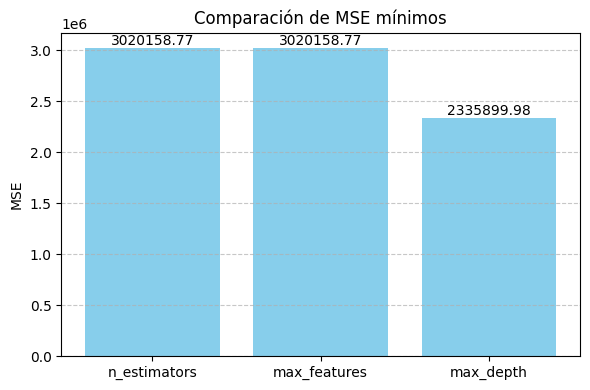

In [25]:
labels = ['n_estimators', 'max_features', 'max_depth']
values = [min_mse_1, min_mse_2, min_mse_3]

# Crear la gráfica de barras
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color='skyblue')
plt.ylabel('MSE')
plt.title('Comparación de MSE mínimos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.05, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Prueba de calibración con todos los parámetros en simultaneo (RandomizedSearchCV)

Luego de consultar técnicas de calibración para modelos basados en árboles de decisión, se encontró que las más recomendadas son GridSearchCV y RandomizedSearchCV. En este caso, se optará por utilizar **RandomizedSearchCV**, ya que esta técnica considera combinaciones aleatorias y no secuenciales, como se hizo en el ejercicio anterior. Esto permite ejecutar la búsqueda una sola vez, reduce el tiempo de cómputo y optimiza los hiperparámetros en función de las combinaciones evaluadas.

In [26]:
# Establecemos el modelo Random Forest nuevamente con las mismas condiciones inciales
reg = RandomForestRegressor(random_state=0)

# Definimos los rangos para los hiperparámetros
param_dist = {
    'n_estimators': randint(50, 300),         # Número de árboles
    'max_depth': randint(3, 30),              # Profundidad máxima de los árboles
    'max_features': [None, 'sqrt', 'log2']  # Cantidad de variables por división
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=20,                    # Número de combinaciones a probar en este ejercicio
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=0,
)

# Entrenamos el RandomizedSearchCV
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)

# Mostramos los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Métricas de evaluación
mse_random = mean_squared_error(y_test, y_pred)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluación del mejor modelo en el conjunto de test:")
print(f"MSE  : {mse_random:.2f}")
print(f"RMSE : {rmse_random:.2f}")
print(f"MAE  : {mae_random:.2f}")

Mejores parámetros encontrados:
{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 129}

Evaluación del mejor modelo en el conjunto de test:
MSE  : 2419578.60
RMSE : 1555.50
MAE  : 1142.47


In [27]:
# Validación cruzada con MSE
rmse_cv = -cross_val_score(random_search, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("Resumen MSE (validación cruzada):")
print(pd.Series(rmse_cv).describe())

Resumen MSE (validación cruzada):
count    5.000000e+00
mean     2.309026e+06
std      7.774075e+04
min      2.187643e+06
25%      2.289466e+06
50%      2.318388e+06
75%      2.362285e+06
max      2.387345e+06
dtype: float64


### Comparación

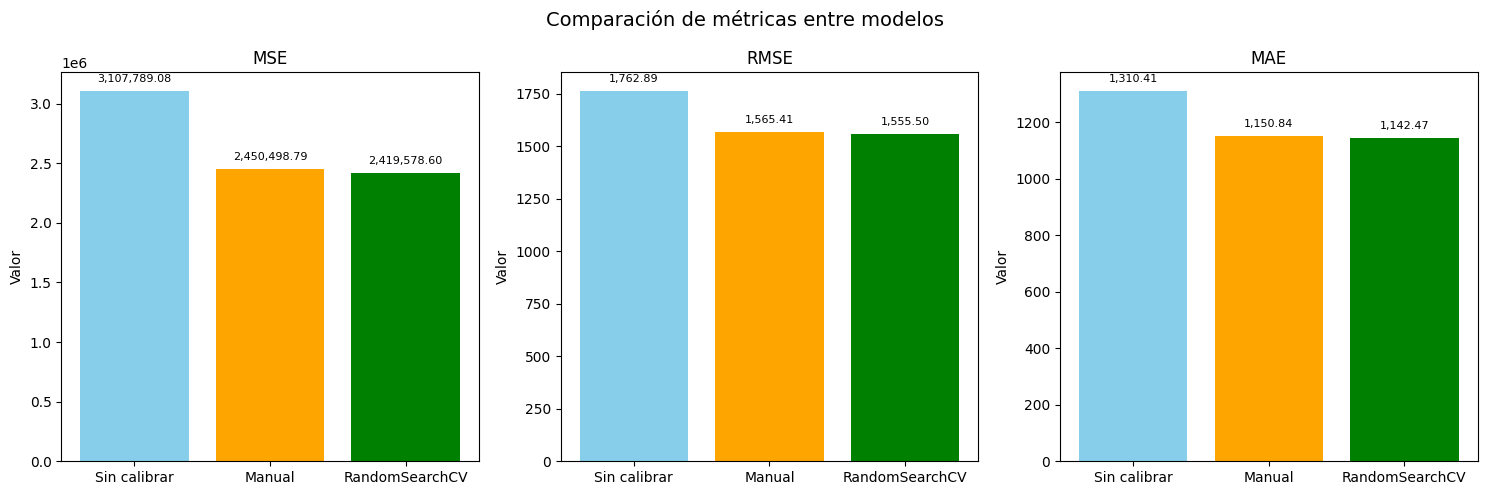

In [28]:
metricas = ['MSE', 'RMSE', 'MAE']
modelos = ['Sin calibrar', 'Manual', 'RandomSearchCV']

# Tus métricas previamente calculadas
modelo_sin_calibrar = [mse_sin_calibrar, rmse_sin_calibrar, mae_sin_calibrar]
modelo_manual = [mse_manual, rmse_manual, mae_manual]
modelo_random = [mse_random, rmse_random, mae_random]

# Transponer para tener los valores por métrica
valores = np.array([modelo_sin_calibrar, modelo_manual, modelo_random]).T

# Crear los subgráficos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    bars = axs[i].bar(modelos, valores[i], color=['skyblue', 'orange', 'green'])
    axs[i].set_title(metricas[i])
    axs[i].set_ylabel('Valor')

    # Etiquetas sobre las barras
    for bar in bars:
        height = bar.get_height()
        axs[i].annotate(f'{height:,.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),  # Desplazamiento
                        textcoords='offset points',
                        ha='center', va='bottom',
                        fontsize=8)

plt.suptitle('Comparación de métricas entre modelos', fontsize=14)
plt.tight_layout()
plt.show()

### Análisis
Al comparar los tres enfoques evaluados, se evidencia que la calibración del modelo mejora significativamente su desempeño. El modelo sin calibrar presenta los errores más altos en todas las métricas (MSE, RMSE y MAE), mientras que la calibración manual permite una mejora sustancial en la precisión. No obstante, el modelo ajustado mediante RandomizedSearchCV obtiene los mejores resultados, al reducir aún más los errores y optimizar el rendimiento general. Esta técnica, al explorar combinaciones aleatorias de hiperparámetros, no solo mejora la eficiencia computacional, sino que también maximiza la capacidad predictiva del modelo con menos esfuerzo manual.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [29]:
xbg_m = XGBRegressor()
scr_rmse = math.sqrt(-1*(cross_val_score(xbg_m,X,y,cv=cv,scoring='neg_mean_squared_error').mean()))
scr_mae = -1 * (cross_val_score(xbg_m,X,y,cv=cv,scoring='neg_mean_absolute_error').mean())

#### Respuesta: Resultados XGboost e interpretación
Se observa que el RMSE (Raíz del Error Cuadrático Medio) es de 1583.20, y el MAE (Error Absoluto Medio) es de 1167.22.

Lo anterior implica que el modelo XGboost que se generó en la celda anterior, se desvía arroneamente en 1583.20 unidades con respecto al precio real. Asimismo, de acuerdo con el MAE, el modelo también se estaría desviando en 1167.22 unidades (precio) con respecto a los valores reales.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [30]:
scr_rmse_cal = []
scr_mae_cal = []

lr = np.arange(0.01, 0.2, 0.01)

for i in lr:
    xbg_cal = XGBRegressor(learning_rate = i, ramdom_state = 0)
    xgb_cal_rmse = math.sqrt(-1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_squared_error').mean()))
    xgb_cal_mae = -1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_absolute_error').mean())
    scr_rmse_cal.append(xgb_cal_rmse)
    scr_mae_cal.append(xgb_cal_mae)

min_rmse_1 = min(scr_rmse_cal)
optimal_n_estimators_rmse = lr[scr_rmse_cal.index(min_rmse_1)]

min_mae_1 = min(scr_mae_cal)
optimal_n_estimators_mae = lr[scr_mae_cal.index(min_mae_1)]

print(f"\nEl menor RMSE es {min_rmse_1:.2f}, obtenido con learning_rate = {optimal_n_estimators_rmse}")
print(f"\nEl menor MAE es {min_mae_1:.2f}, obtenido con learning_rate = {optimal_n_estimators_mae}")


El menor RMSE es 1520.12, obtenido con learning_rate = 0.04

El menor MAE es 1116.31, obtenido con learning_rate = 0.05


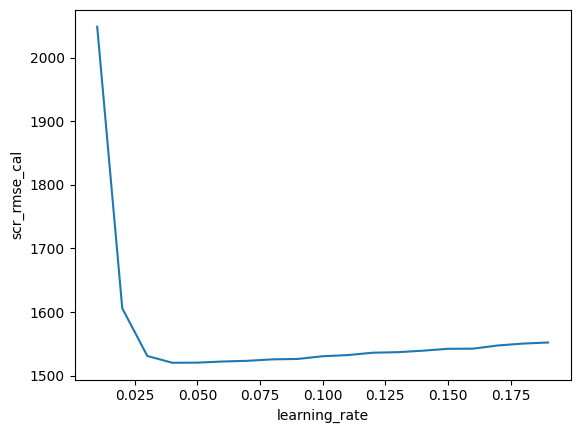

In [31]:
plt.plot(lr, scr_rmse_cal)
plt.xlabel('learning_rate')
plt.ylabel('scr_rmse_cal')
plt.show()

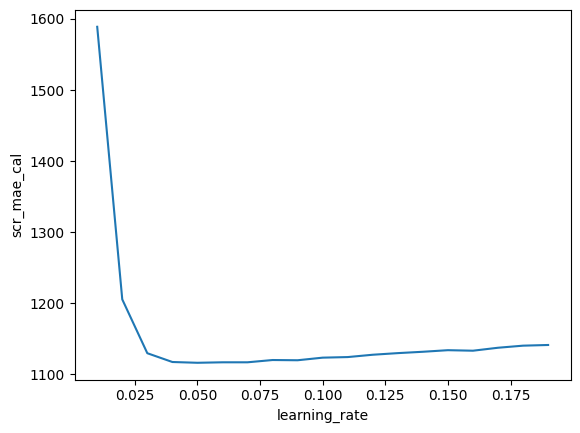

In [32]:
plt.plot(lr, scr_mae_cal)
plt.xlabel('learning_rate')
plt.ylabel('scr_mae_cal')
plt.show()

In [33]:
print("Tanto el RMSE como el MAE parecen sugerir el error se minimiza al rededor del intervalo 0.03 - 0.05. Es por esta razón que para el \
learning rate se utilizará un valor de 0.04 el cual corresponde a un RMSE de 1520.12.")

Tanto el RMSE como el MAE parecen sugerir el error se minimiza al rededor del intervalo 0.03 - 0.05. Es por esta razón que para el learning rate se utilizará un valor de 0.04 el cual corresponde a un RMSE de 1520.12.


In [34]:
scr_rmse_cal = []
scr_mae_cal = []

gamma_cal = np.arange(0.01, 1, 0.1)
gamma_cr = np.round(gamma_cal, 2)

for i in gamma_cr:
    xbg_cal = XGBRegressor(learning_rate = 0.04, gamma=i, ramdom_state = 0)
    xgb_cal_rmse = math.sqrt(-1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_squared_error').mean()))
    xgb_cal_mae = -1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_absolute_error').mean())
    scr_rmse_cal.append(xgb_cal_rmse)
    scr_mae_cal.append(xgb_cal_mae)

min_rmse_1 = min(scr_rmse_cal)
optimal_n_estimators_rmse = lr[scr_rmse_cal.index(min_rmse_1)]

min_mae_1 = min(scr_mae_cal)
optimal_n_estimators_mae = lr[scr_mae_cal.index(min_mae_1)]

print(f"\nEl menor RMSE es {min_rmse_1:.2f}, obtenido con gamma = {optimal_n_estimators_rmse}")
print(f"\nEl menor MAE es {min_mae_1:.2f}, obtenido con gamma = {optimal_n_estimators_mae}")


El menor RMSE es 1520.12, obtenido con gamma = 0.01

El menor MAE es 1117.41, obtenido con gamma = 0.01


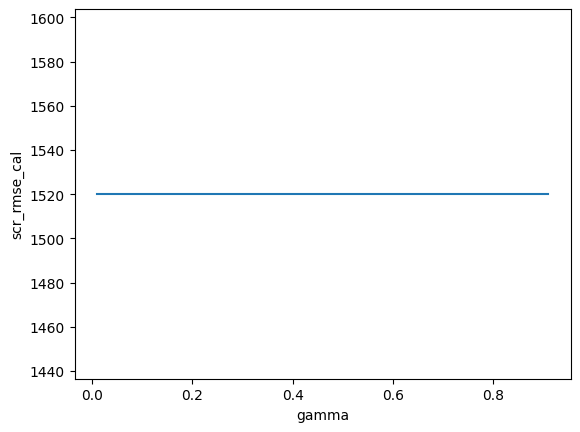

In [35]:
plt.plot(gamma_cr, scr_rmse_cal)
plt.xlabel('gamma')
plt.ylabel('scr_rmse_cal')
plt.show()

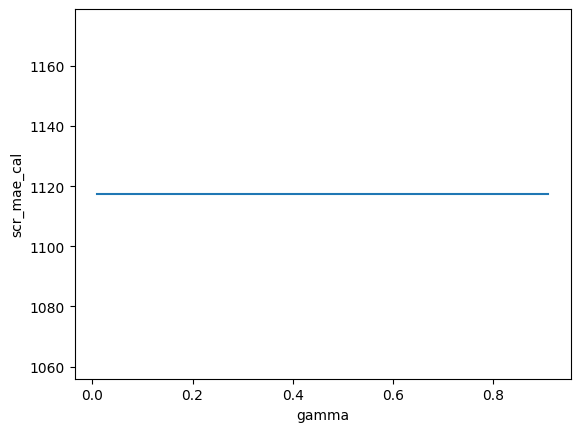

In [36]:
plt.plot(gamma_cr, scr_mae_cal)
plt.xlabel('gamma')
plt.ylabel('scr_mae_cal')
plt.show()

In [37]:
print("Tanto el RMSE como el MAE parecen sugerir al variar el parámetro gamma no se observa una variación en el error. Es por esta razón que para el \
parámetro gamma no se utilizará ningún valor.")

Tanto el RMSE como el MAE parecen sugerir al variar el parámetro gamma no se observa una variación en el error. Es por esta razón que para el parámetro gamma no se utilizará ningún valor.


In [38]:
scr_rmse_cal = []
scr_mae_cal = []

colsample_bytree_cal = np.arange(0.1, 1.1, 0.1)

for i in colsample_bytree_cal:
    xbg_cal = XGBRegressor(learning_rate = 0.04, colsample_bytree=i, ramdom_state = 0)
    xgb_cal_rmse = math.sqrt(-1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_squared_error').mean()))
    xgb_cal_mae = -1*(cross_val_score(xbg_cal,X,y,cv=5,scoring='neg_mean_absolute_error').mean())
    scr_rmse_cal.append(xgb_cal_rmse)
    scr_mae_cal.append(xgb_cal_mae)

min_rmse_1 = min(scr_rmse_cal)
optimal_n_estimators_rmse = lr[scr_rmse_cal.index(min_rmse_1)]

min_mae_1 = min(scr_mae_cal)
optimal_n_estimators_mae = lr[scr_mae_cal.index(min_mae_1)]

print(f"\nEl menor RMSE es {min_rmse_1:.2f}, colsample_bytree = {optimal_n_estimators_rmse}")
print(f"\nEl menor MAE es {min_mae_1:.2f}, colsample_bytree = {optimal_n_estimators_mae}")


El menor RMSE es 1516.41, colsample_bytree = 0.08

El menor MAE es 1116.18, colsample_bytree = 0.09


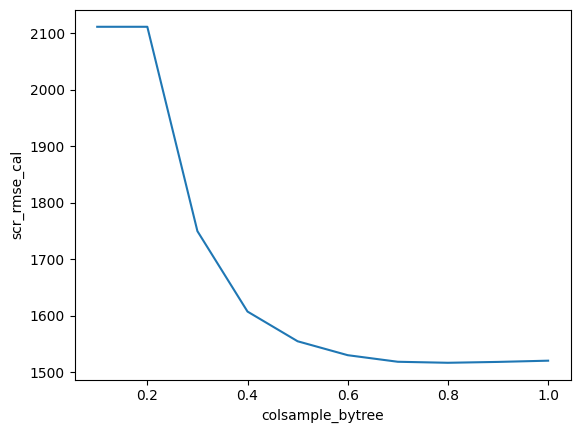

In [39]:
plt.plot(colsample_bytree_cal, scr_rmse_cal)
plt.xlabel('colsample_bytree')
plt.ylabel('scr_rmse_cal')
plt.show()

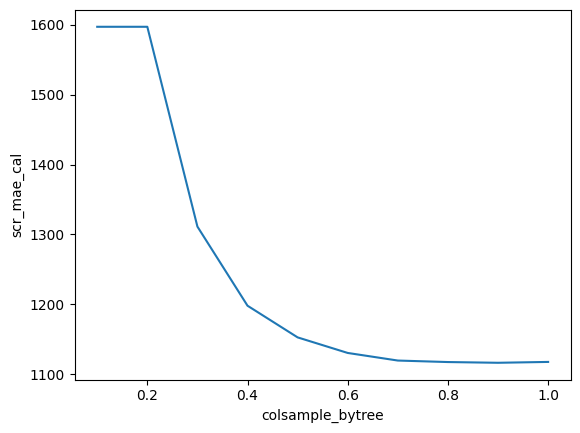

In [40]:
plt.plot(colsample_bytree_cal, scr_mae_cal)
plt.xlabel('colsample_bytree')
plt.ylabel('scr_mae_cal')
plt.show()

In [41]:
print("Se observa que el error medido tanto con el RMSE como con el MAE tiende a estabilizarse en el parámetro colsample_bytree en el intervalo 0.8 - 1.0. \
En ese sentido, se elige el valor 0.8 en virtud de que brinda el menor RME con un valor de 1516.41.")

Se observa que el error medido tanto con el RMSE como con el MAE tiende a estabilizarse en el parámetro colsample_bytree en el intervalo 0.8 - 1.0. En ese sentido, se elige el valor 0.8 en virtud de que brinda el menor RME con un valor de 1516.41.


In [42]:
# Modelo calibrado
xbg_def = XGBRegressor(learning_rate = 0.04, colsample_bytree=0.8)

scr_rmse_def = math.sqrt(-1*(cross_val_score(xbg_def,X,y,cv=5,scoring='neg_mean_squared_error').mean()))
scr_mae_def = -1 * (cross_val_score(xbg_def,X,y,cv=5,scoring='neg_mean_absolute_error').mean())

print(scr_rmse_def)
print(scr_mae_def)

1516.407118817371
1117.23193359375


#### Respuesta: resultado XGBoost calibrado
Se observa que, para el modelo calibrado, el RMSE (Raíz del Error Cuadrático Medio) es de 1516.40, y el MAE (Error Absoluto Medio) es de 1117.23.

Lo anterior implica que el modelo XGboost que se generó en la celda anterior, se desvía arroneamente en 1516.40 unidades con respecto al precio real. Asimismo, de acuerdo con el MAE, el modelo también se estaría desviando en 1117.23 unidades (precio) con respecto a los valores reales.

#### Respuesta: resultado XGBoost progreso con cada parámetro calibrado
En primer lugar, se procedió con la calibración del parámetro learning_rate. Se realizó una iteración para todo el conjunto de valores datos por el intervalo 0.01 - 0.2 con incrementos de 0.01. Tanto el RMSE como el MAE parecen sugerir el error se minimiza al rededor del intervalo 0.03 - 0.05. De ahí que se utilizará un valor de 0.04 el cual corresponde a un RMSE de 1520.12. Posteriormente, en el caso del parámetro gamma, tanto el RMSE como el MAE parecen sugerir al variar dicho parámetro no se observa una variación en el error para los valores dados en el intervalo 0.01 - 1 con incrementos de 0.1. Es por esta razón que, para el parámetro gamma, se utilizará su valor por defecto. Por último, ne cuanto al parámetro colsample_bytree, se realizaron iteraciones para el intervalo 0.1 - 1.1 con incrementos de 0.1. Se observa que el error medido tanto con el RMSE como con el MAE tiende a estabilizarse en el parámetro colsample_bytree en el intervalo 0.8 - 1.0. En ese sentido, se elige el valor 0.8 en virtud de que brinda el menor RME con un valor de 1516.41.

Finalmente, el modelo calibrado posee un RMSE de 1516.40 y un MAE de 1117.23.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

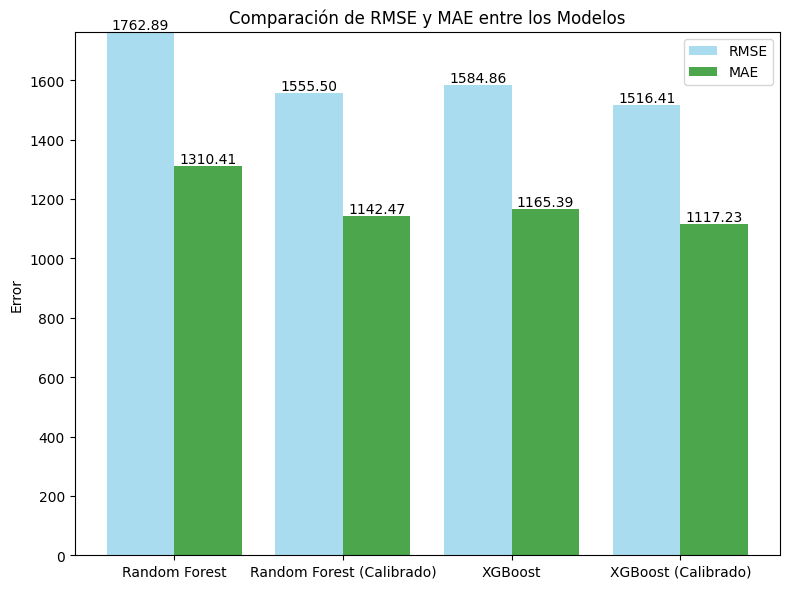

In [43]:
# Celda 8
modelos = ["Random Forest", "Random Forest (Calibrado)", "XGBoost", "XGBoost (Calibrado)"]
rmse_scores = [rmse_sin_calibrar, rmse_random, scr_rmse, scr_rmse_def]
mae_scores = [mae_sin_calibrar, mae_random, scr_mae, scr_mae_def]

x = np.arange(len(modelos))

plt.figure(figsize=(8, 6))

# Gráfico de barras
bars_rmse = plt.bar(x - 0.2, rmse_scores, 0.4, label="RMSE", color="skyblue", alpha=0.7)
bars_mae = plt.bar(x + 0.2, mae_scores, 0.4, label="MAE", color="green", alpha=0.7)

# Etiquetas en las barras
for bar in bars_rmse:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)
for bar in bars_mae:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10)

# Configuración del gráfico
plt.xticks(x, modelos)
plt.ylabel("Error")
plt.title("Comparación de RMSE y MAE entre los Modelos")
plt.legend()
plt.ylim(0, max(max(rmse_scores), max(mae_scores)) + 0.1)
plt.tight_layout()

plt.show()

XGBoost calibrado ofrece el menor RMSE y MAE, siendo claramente el modelo más robusto y preciso. 
Random Forest sin calibrar tiene el peor desempeño en ambas métricas, y representa el modelo menos confiable si se busca precisión en predicción de precios de automóviles.  
La calibración mejora notablemente ambos modelos, pero XGBoost resultó ser el mejor, lo que es consistente con la literatura, ya que este modelo suele superar a Random Forest en muchos escenarios por su capacidad para manejar relaciones complejas entre variables y por sus herramientas integradas de regularización. 

**Ventajas mejor modelo: XGBoost Calibrado:**  
- Este modelo muestra un mejor desempeño en ambas métricas (RMSE y MAE). En promedio, el modelo desvía solo $1117.23 respecto al valor real del auto.
- Modelo más preciso al tener menor error cuadrátrico medio, lo cual es clave cuando los errores grandes son penalizados más fuertemente.  
- La calibración (ajustando learning_rate y colsample_bytree) mejora la capacidad de generalización a nuevos datos .
- Captura relaciones no lineales entre variables.
- Regularización automática que previene sobreajuste.
- Ideal si el precio del automovil esta afectado por múltiples interraciones entre variables.

**Desventajas por modelo: Random Forest sin calibrar:**
- Errores significativamente más altos. El modelo se desvía en promedio $1310.41, un 17% más que XGBoost Calibrado.
- Al no aplicarse ajuste de hiperparámetros puede llevar a un rendimiento subóptimo por defecto.
- Falta de tuning lo hace ineficiente para un problema con muchas variables correlacionadas.
- Es más rígido que XGBoost en términos de regularización y no gestiona tan bien relaciones complejas o interacciones entre variables.